# 瞭解如何使用計數方法詞向量與 SVD

* 將文字資料輸入模型進行自然語言任務之前，其中一項重要的前處理即為將字詞向量化(詞嵌入 word embedding)。
* 而將詞向量化的方法有很多，這裡我們會著重在介紹如何使用計數方法來將字詞向量化。

---
## 字詞前處理

* 在進行字詞向量化之前，我們需要針對文本資料進行前置處理，將**文本資料分割成字詞(斷詞)**，再將分割後的**字詞轉換成字詞ID清單**。

### 導入會使用的 library

In [2]:
import re
import numpy as np
from typing import List  # 型別註釋(type annotations)

### 定義前處理函式

In [3]:
def preprocess(corpus: List[str], only_word: bool = False):
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    '''
    word_dic = set()
    processed_sentence = []
    
    for sentence in corpus:
        # 將所有字詞轉為小寫
        sentence = sentence.lower()

        # 移除標點符號 (可以依據使用狀況決定是否要移除標點符號)
        if only_word:
            pattern = r'[^\W_]+'
            sentence = re.findall(pattern, sentence)
        else:
            punctuation_list = ['.', ',', '!', '?']
            for pun in punctuation_list:
                sentence = sentence.replace(pun, ' '+pun)
            sentence = sentence.split(' ')
        
        # 添加字詞到字典中
        word_dic |= set(sentence)  # in_place operation
        processed_sentence.append(sentence)
    
    
    # 建立字詞 ID 清單
    word2idx = dict()
    idx2word = dict()
    for word in word_dic:
        if word not in word2idx:
            idx = len(word2idx)
            word2idx[word] = idx
            idx2word[idx] = word

    # 將文本轉為 ID 型式
    id_mapping = lambda x: word2idx[x]
    
    corpus = np.array([list(map(id_mapping, sentence)) for sentence in processed_sentence])

    return corpus, word2idx, idx2word

# 定義簡易文本資料 (使用講義中的例子)
corpus = ['You say goodbye and I say hello.']

processed_corpus, word2idx, idx2word = preprocess(corpus)
print(f'Processed corpus: {processed_corpus} \n word2idx: {word2idx} \n idx2word: {idx2word}')

Processed corpus: [[3 5 1 4 2 5 6 0]] 
 word2idx: {'.': 0, 'goodbye': 1, 'i': 2, 'you': 3, 'and': 4, 'say': 5, 'hello': 6} 
 idx2word: {0: '.', 1: 'goodbye', 2: 'i', 3: 'you', 4: 'and', 5: 'say', 6: 'hello'}


---
## 共現矩陣
將轉化處理過的文本資料轉化為共現矩陣

### 定義共現矩陣函式 (method 1)

In [4]:
def create_co_matrix(corpus: np.ndarray, vocab_size: int, window_size: int=1):
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype=np.int32)
    
    for sentence in corpus:
        sentence_size = len(sentence)
    
        for idx, word_id in enumerate(sentence):
            for i in range(1, window_size+1):
                left_idx = idx - i
                right_idx = idx + i

                if left_idx >= 0:
                    left_word_id = sentence[left_idx]
                    co_matrix[word_id, left_word_id] += 1

                if right_idx < sentence_size:
                    right_word_id = sentence[right_idx]
                    co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

co_matrix = create_co_matrix(processed_corpus, len(word2idx), 2)
co_matrix

array([[0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 2, 0],
       [1, 1, 1, 1, 2, 0, 1],
       [1, 0, 1, 0, 0, 1, 0]], dtype=int32)

### 定義共現矩陣函式 (method 2)

In [7]:
corpus

['You say goodbye and I say hello.']

In [6]:
processed_corpus

array([[3, 5, 1, 4, 2, 5, 6, 0]])

In [8]:
def create_co_matrix(corpus: np.ndarray, vocab_size: int, window_size: int=1):
    # initialize co-occurrence matrix
    co_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype=np.int32)
    
    for sentence in corpus:
        sentence_size = len(sentence)
    
        for idx, word_id in enumerate(sentence):
            left_idx = idx - window_size if idx - window_size >= 0 else 0
            context_ids = sentence[left_idx:idx]
            
            for left_i, left_id in enumerate(context_ids):
                co_matrix[word_id, left_id] += 1
                co_matrix[left_id, word_id] += 1

    return co_matrix

co_matrix = create_co_matrix(processed_corpus, len(word2idx), 2)
co_matrix

array([[0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 2, 0],
       [1, 1, 1, 1, 2, 0, 1],
       [1, 0, 1, 0, 0, 1, 0]], dtype=int32)

---
## 向量相似度
* 比較轉換為向量的字詞的方法有很多種，其中當要表示字詞的相似度時，最常使用的方法為餘弦相似度 (Cosine Similarity)

$$
sim(x,y) = \frac{xy}{||x||||y||}
$$

### 定義餘弦相似度

In [9]:
def cos_similarity(x: np.ndarray, y: np.ndarray, eps: float=1e-8):
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    
    return np.dot(nx,ny)

# calculate the similarity between I and you
cos_similarity(co_matrix[word2idx['i']], co_matrix[word2idx['you']])

0.7071067726510136

## 建立可供查詢相似度的函數
* 輸入字詞，查詢與此字詞 top_n 相似的結果

In [10]:
def top_k_similarity(query: str, word2idx: dict, idx2word: dict, word_matrix: np.ndarray, top_k: int=3):
    
    # handle the situation of query word not in corpus
    if query not in word2idx:
        raise ValueError(f"{query} is not found in input dictionary")
    
    # handle the situation of top_k is the same as the amount of words
    if top_k >= len(word2idx):
        raise ValueError(f"top_k needs to be less than the amount of words")
        
    print(f"[query] : {query}")
    query_id = word2idx[query]
    query_vec = word_matrix[query_id]
    
    # calculate cosine similarity
    similarity_scores = np.zeros(len(word2idx))
    for i in range(len(word2idx)):
        similarity_scores[i] = cos_similarity(query_vec, word_matrix[i])

    # remove query word
    similarity_scores[query_id] = 0
    filter_word2idx = dict([(k, v) for k, v in word2idx.items() if k != query])
    filter_idx2word = dict([(k, v) for k, v in idx2word.items() if k != query_id])
    
    # sorting by similarity score
    top_k_idx = (-similarity_scores).argsort()[:top_k] # np.argsort(): 從小到大排列並提取對應的index
    top_k_word = [filter_idx2word[word_idx] for word_idx in top_k_idx]
    
    return dict(zip(top_k_word, similarity_scores[top_k_idx]))

In [11]:
top_k_similarity('you', word2idx, idx2word, co_matrix, 3)

[query] : you


{'and': 0.8660253941251803, 'i': 0.7071067726510136, '.': 0.49999999292893216}

---
## 正向點間互資訊 (PPMI)
* 由於共生矩陣在高頻字上的缺陷，而PMI中加入了兩字詞共同出現的機率與各自出現的機率的關係，以此解決高頻詞在共生矩陣上的缺陷。

* 而 PPMI 即將 PMI 內會產生負值的情況排除(若出現負值則賦予 0)

$$
\begin{aligned}
&PMI(x,y) = log_2\frac{P(x,y)}{P(x)P(y)} = log_2\frac{C(x,y)N}{C(x)C(y)} \\
&PPMI(x,y) = max(0,PMI(x,y))
\end{aligned}
$$

### 定義正向點間互資訊

In [13]:
def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    # np.zeros_like(): 創建一個跟給定陣列相同大小的全 0 陣列
    N = np.sum(co_matrix)
    M = np.zeros_like(co_matrix, dtype=np.float32)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0] * co_matrix.shape[1]

    cnt = 0
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

In [14]:
output_ppmi = ppmi(co_matrix, verbose=True)
output_ppmi

10/49 Done
20/49 Done
30/49 Done
40/49 Done
49/49 Done


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.8930848,
        2.1154773],
       [0.       , 0.       , 0.7004397, 1.7004397, 0.7004397, 0.       ,
        0.       ],
       [0.       , 0.7004397, 0.       , 0.       , 0.7004397, 0.       ,
        1.1154772],
       [0.       , 1.7004397, 0.       , 0.       , 0.       , 0.8930848,
        0.       ],
       [0.       , 0.7004397, 0.7004397, 0.       , 0.       , 0.8930848,
        0.       ],
       [0.8930848, 0.       , 0.       , 0.8930848, 0.8930848, 0.       ,
        0.3081223],
       [2.1154773, 0.       , 1.1154772, 0.       , 0.       , 0.3081223,
        0.       ]], dtype=float32)

---
## SVD
* 觀察上面的 PPMI 輸出矩陣，可以發現大部分的元素都為 0 (稀疏矩陣)，因此可以發現此矩陣包含了許多無法提供訊息的元素
* 利用奇異值分解，將矩陣降維，並保存重要的資訊。

### 使用 np 的 `linalg.svd()` 對 PPMI 矩陣進行奇異值分解

In [15]:
# SVD
U, S, V = np.linalg.svd(output_ppmi)

# 使用SVD將將原本的稀疏向量轉變為稠密向量
print(f"hello in co-occurrence matrix: {co_matrix[word2idx['hello']]}")
print(f"hello in PPMI: {output_ppmi[word2idx['hello']]}")
print(f"hello in SVD: {U[word2idx['hello']]}")

hello in co-occurrence matrix: [1 0 1 0 0 1 0]
hello in PPMI: [2.1154773 0.        1.1154772 0.        0.        0.3081223 0.       ]
hello in SVD: [-0.5126197   0.5698161  -0.39725903 -0.4323913  -0.01054526  0.124419
  0.22839099]


In [16]:
# 檢查分解是否正確
# a @ b = dot(a, b)
A = U @ np.diag(S) @ V  
print(A)
print(output_ppmi)
# 可以發現 SVD 後，結果跟原來的 output_ppmi 是相同的

[[-3.3683197e-08 -7.4080468e-08  2.2216554e-08 -4.0760728e-08
  -8.4676607e-08  8.9308482e-01  2.1154773e+00]
 [-6.8160695e-09  5.8041792e-08  7.0043969e-01  1.7004398e+00
   7.0043969e-01  5.6385137e-09 -7.4432329e-08]
 [ 2.0622537e-08  7.0043969e-01  2.3153314e-08  3.5444103e-08
   7.0043969e-01  2.2115112e-08  1.1154772e+00]
 [-4.8094705e-08  1.7004397e+00  3.7209105e-08 -4.0341142e-08
   1.4502533e-09  8.9308476e-01 -4.3083389e-08]
 [-8.3527041e-08  7.0043969e-01  7.0043969e-01 -4.4883759e-08
  -2.3019233e-08  8.9308482e-01 -4.3795090e-08]
 [ 8.9308482e-01  4.0985121e-08  5.5780403e-09  8.9308482e-01
   8.9308482e-01  1.0392343e-08  3.0812228e-01]
 [ 2.1154773e+00 -1.3404321e-08  1.1154772e+00 -6.0040975e-08
  -4.2378574e-08  3.0812228e-01 -5.6422177e-08]]
[[0.        0.        0.        0.        0.        0.8930848 2.1154773]
 [0.        0.        0.7004397 1.7004397 0.7004397 0.        0.       ]
 [0.        0.7004397 0.        0.        0.7004397 0.        1.1154772]
 [0.      

In [17]:
# 可以發現前六個奇異值就佔了絕大多數的奇異值
print(S)

# 可以取前六個維度當作降維的詞向量
U_reduce = U[:, 0:6]
U_reduce

[2.9371588  2.5547988  2.1101685  1.9556583  1.1257027  0.58972406
 0.30812874]


array([[-0.48203   , -0.56445074,  0.26282662, -0.430857  , -0.33953863,
        -0.2642201 ],
       [-0.31352073,  0.30776063,  0.48896635,  0.5457005 , -0.38465765,
         0.12412582],
       [-0.33312967, -0.30777904,  0.16466641,  0.03673923,  0.5294517 ,
         0.6964652 ],
       [-0.29432744, -0.29746115, -0.5294562 ,  0.511355  ,  0.22169203,
        -0.35262936],
       [-0.26702777, -0.09261478, -0.3523957 ,  0.24547683, -0.44945022,
         0.26410997],
       [-0.3710324 ,  0.26495245,  0.31999645,  0.0807369 ,  0.45295563,
        -0.4691856 ],
       [-0.5126197 ,  0.5698161 , -0.39725903, -0.4323913 , -0.01054526,
         0.124419  ]], dtype=float32)

### 繪製視覺化圖表

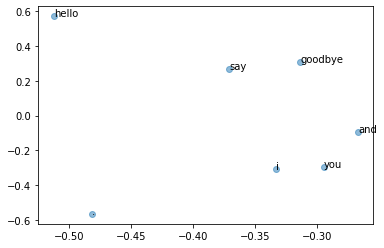

In [18]:
import matplotlib.pyplot as plt

# 將詞向量降為二維方便視覺化
U_visualization = U[:, 0:2]

# visualization
for word, word_id in word2idx.items():
    plt.annotate(word, (U_reduce[word_id, 0], U_reduce[word_id, 1]))
    
plt.scatter(U_reduce[:, 0], U_reduce[:, 1], alpha=0.5)
plt.show()